# SNN with hierarchy of Time constant
---
This notebook is mainly for developing the code that will be rewritten in python files\\

The idea is to explore what role a hierarchy of time scales have in temporal processing, especially when dealing with multi-time-scale inputs.\\

Prior literature shows the importance of heterogeneity of time scales in SNNs, mainly showing that diversity of time-scales are beneficial.
- https://www.nature.com/articles/s41467-021-26022-3
- https://www.nature.com/articles/s41467-023-44614-z

However, an interpretation of the role of the hierarchy of time constant is still missing.

The assumption is that when treating a temporal sequence sempled at a certain period $\tau_{sampling}$ and with a total duration $\Tau$, there can be an optimal sequence of filters $F_i(\tau_i)$ that process the input sequence. For each of the filters $\tau_{i+1} > \tau_i$, where the subscript indicates the order of the filter. More simply, there is a hierarchy of time-scales - from fast to slow - that leads to an optimal processing of the input sequence.

In [1]:
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random

from jax import vmap, jit, value_and_grad, local_device_count
from jax.example_libraries import optimizers
from jax.lax import scan, cond
import pickle

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".25" # needed because network is huge
os.environ["CUDA_VISIBLE_DEVICES"]="2"
jax.devices()

I0000 00:00:1714671223.817543       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[CpuDevice(id=0)]

# Hyperparameter sweep
---
performed with WandB

In [ ]:
import wandb
wandb.login()

## Parameters of the SNN model
---

In [3]:
from utils_initialization import SimArgs
args = SimArgs()

## Training function
---

In [4]:
from training import train_hsnn_wandb

# Sweep Configuration

In [5]:
sweep_config = {
    'method': 'grid',
}

metric = {
    'name': 'accuracy',
    'goal': 'maximize'
    }
sweep_config['metric'] = metric

config = {}
for i, [key, value] in enumerate( zip( args.__dict__.keys(), args.__dict__.values()  ) ):
    config[key] = {'value': value}
# update the parameters to sweep
config['tau_mem'] = {'values':[0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.8]}
config['seed'] = {'values':[0]}
config['n_epochs'] = {'value':5}
config['n_layers'] = {'value':4}

sweep_config['parameters'] = config

In [6]:
sweep_id = wandb.sweep(sweep_config, project="Tau_mem_short")

Create sweep with ID: qa0lo9cv
Sweep URL: https://wandb.ai/filomo14/Tau_mem_short/sweeps/qa0lo9cv


In [ ]:
wandb.agent(sweep_id, train_hsnn_wandb)

# Single Round
---
We'll use Leaky-Integrate-and-Fire neurons for the Hidden layers, Leaky-Integrator neurons for the output.

We also define some additional functions to: Introduce Noise in Weights and Membrane voltage, Introduce the Surrogate Gradient function.

In [2]:
from models import *
from utils_initialization import *
from training import *

In [13]:
args.train_alpha = False
args.hierarchy_tau = False
args.distrib_tau = 'uniform'
args.recurrent = False
args.normalizer = 'batch' # 'batch' #'layer'
args.n_layers = 4
# time constants
args.tau_mem = 0.1 #0.1
args.delta_tau = 0.075

# LR and regularizers
if args.recurrent: args.lr = 0.01
else: args.lr = 0.01
args.lr_decay = 0.5
args.lr_decay_every = 50
args.l2_lambda = 0 #1e-6
args.freq_lambda = 0 #1e-6
args.dropout_rate = 0.1
args.n_epochs = 10
args.decoder = 'cum'
args.dataset_name = 'shd'
args.n_out = 20 if args.dataset_name == 'shd' else 35  # output channels

# Training
train_loss, test_acc, val_acc, net_params_best = train_hsnn( args = args )

Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
Epoch: [1/10] - Loss: 1.41066 -  Training acc: 34.38 - Validation acc: 57.48 - t: 7.24 sec
Epoch: [2/10] - Loss: 0.93184 -  Training acc: 68.30 - Validation acc: 75.25 - t: 3.49 sec
Epoch: [3/10] - Loss: 0.51035 -  Training acc: 79.87 - Validation acc: 83.52 - t: 3.46 sec
Epoch: [4/10] - Loss: 0.45039 -  Training acc: 86.16 - Validation acc: 87.93 - t: 3.47 sec
Epoch: [5/10] - Loss: 0.36980 -  Training acc: 88.17 - Validation acc: 88.42 - t: 3.48 sec
Epoch: [6/10] - Loss: 0.29229 -  Training acc: 90.50 - Validation acc: 90.26 - t: 3.59 sec
Epoch: [7/10] - Loss: 0.40782 -  Training acc: 91.78 - Validation acc: 89.95 - t: 3.50 sec
Epoch: [8/10] - Loss: 0.25025 -  Training acc: 93.62 - Validation acc: 90.62 - t: 3.51 sec
Epoch: [9/10] - Loss: 0.16908 -  Training acc: 94.13 - Validation acc: 93.14 - t: 3.52 sec
Epoch: [10/10] - Loss: 0.18330 -  Training acc: 95.05 - Validation acc: 92.77 - t: 3.52 sec
Validation Accuracy: 93

# HSNN analysis (Supplementary Figure 2)
---
Here we take a pre-trained hSNN model and analyze its performance, trying to understand "how" and "why" it performs well.

In [309]:
# Import model
import pickle, os
dir_models = '/Users/filippomoro/Documents/hsnn/results'
model_path = 'Hierarchy_tau_mem100_delta_tau90_seed0'
model_name = os.path.join( model_path, 'model.pkl' )
file_name = os.path.join( dir_models, model_name ) 
loaded_model = pickle.load( open( file_name, 'rb' ) )
args = loaded_model['args']
net_params_best = loaded_model['net_params_best']

In [313]:
loaded_model['val_acc']

Array(97.05882, dtype=float32)

In [12]:
# Load the test set of the dataset
from utils_dataset import get_dataloader
_, _, test_dl = get_dataloader( args=args, verbose=True )

Train DL size: 8156, Validation DL size: 1632, Test DL size: 2264


In [13]:
from utils_initialization import params_initializer, SimArgs
from utils_normalization import LayerNorm, BatchNorm
from models import lif_step, rlif_step, li_step, dropout
from models import decoder_cum, decoder_freq, decoder_sum, decoder_vlast, decoder_vmax

# selecting the right decoder
decoder_dict = {'cum'  : decoder_cum,
                'sum'  : decoder_sum,
                'vmax' : decoder_vmax,
                'vlast': decoder_vlast,
                'freq' : decoder_freq
                }
if args.decoder in decoder_dict.keys():
    decoder = decoder_dict[args.decoder]
else: 
    print('Unrecognized Decoder, will revert to a "cum"-style decoder')
    print('Next time choose a decoder in: '+str(list(decoder_dict.keys())))
    args.decoder = 'cum'
    decoder = decoder_dict[args.decoder]

# network architecture
if args.recurrent:
    layer = rlif_step
else: 
    layer = lif_step
if args.decoder == 'freq':
    layer_out = lif_step
else: 
    layer_out = li_step
if args.normalizer == 'batch': norm = BatchNorm
elif args.normalizer == 'layer': norm = LayerNorm
else: norm = None

In [24]:
from jax import jit, vmap

@jit
def scan_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer = vmap( scan_layer, in_axes=(None, 0))

@jit
def scan_out_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer_out, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer_out = vmap( scan_out_layer, in_axes=(None, 0))

# the following function implements the main network
@jit
def hsnn( args_in, input_spikes ):
    net_params, net_states, key, dropout_rate = args_in # input arguments
    n_layers = len( net_params )                        # umber of layers
    # collection of output spikes
    out_spike_net = [] # collects the spikes from each layer
    # Loop over the layers
    for l in range(n_layers):
        # selecting the right input (from the previous layer)
        if l == 0: layer_input_spike = input_spikes
        else: layer_input_spike = out_spikes_layer
        # making layers' params and states explitic
        # parameters (weights and alpha) and the state of the neurons (spikes, inputs and membrane, ecc..)
        w, alpha = net_params[l]; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states[l]
        if len(w) == 3: # it means that we'll do normalization
            weight, scale, bias = w
        else: weight = w
        if len(weight) ==2: weight, _ = weight
        # Multiplying the weights by the spikes
        I_in = jnp.matmul(layer_input_spike, weight)
        # Normalization (if selected)
        if len(w) == 3: # it means that we'll do normalization
            b, t, n = I_in.shape
            I_in = norm( I_in.reshape( b*t, n ), bias = bias, scale = scale )
            I_in = I_in.reshape( b,t,n ) # normalized input current
        # Forward pass of the Layer
        args_in_layer = [net_params[l], net_states[l]]
        if l+1 == n_layers:
            _, out_spikes_layer = vscan_layer_out( args_in_layer, I_in )
        else: 
            _, out_spikes_layer = vscan_layer( args_in_layer, I_in )
            # Dropout
            key, key_dropout = jax.random.split(key, 2)
            out_spikes_layer = dropout( key_dropout, out_spikes_layer, rate=dropout_rate, deterministic=False )
        out_spike_net.append(out_spikes_layer)
    return out_spikes_layer, out_spike_net

def one_hot(x, n_class):
    return jnp.array(x[:, None] == jnp.arange(n_class), dtype=jnp.float32)

### Perform inference with the Test set and check the spiking-activity of the network

In [186]:
def run_inference( loaded_model ):
    args = loaded_model['args']
    net_params_best = loaded_model['net_params_best']

    # Initialize states
    _ , net_states = params_initializer(key=jax.random.PRNGKey(args.seed), args=args)

    # Take a new batch
    x_test, y_test = next(iter( test_dl ))

    # Inference
    dropout_rate = 0.
    key=jax.random.PRNGKey(args.seed)
    args_in = [net_params_best, net_states, key, dropout_rate]
    output_layer, out_spike_net = hsnn( args_in, x_test ) # ------------> OUT_SPIKE_NET is what we're after
    Yhat = decoder( output_layer )
    # compute the loss and correct examples
    Y_test = one_hot( y_test, 20 )
    num_correct = jnp.sum(jnp.equal(jnp.argmax(Yhat, 1), jnp.argmax(Y_test, 1)))
    # cross entropy loss
    loss_ce = -jnp.mean( jnp.sum(Y_test * jnp.log(Yhat+1e-12), axis=-1) )
    # L2 norm
    loss_l2 = optimizers.l2_norm( [net_params_best[l][0] for l in range(len(net_params_best))] ) * args.l2_lambda
    # firing rate loss
    avg_spikes_neuron = jnp.mean( jnp.stack( [ jnp.mean( jnp.sum( out_spike_net[l], axis=1 ), axis=(0,-1) ) for l in range( len(net_params_best)-1 )] ) )
    loss_fr = args.freq_lambda * (args.target_fr - avg_spikes_neuron)**2
    # Total loss
    loss_total = loss_ce + loss_l2 + loss_fr
    loss_values = [num_correct, loss_ce]
    return out_spike_net

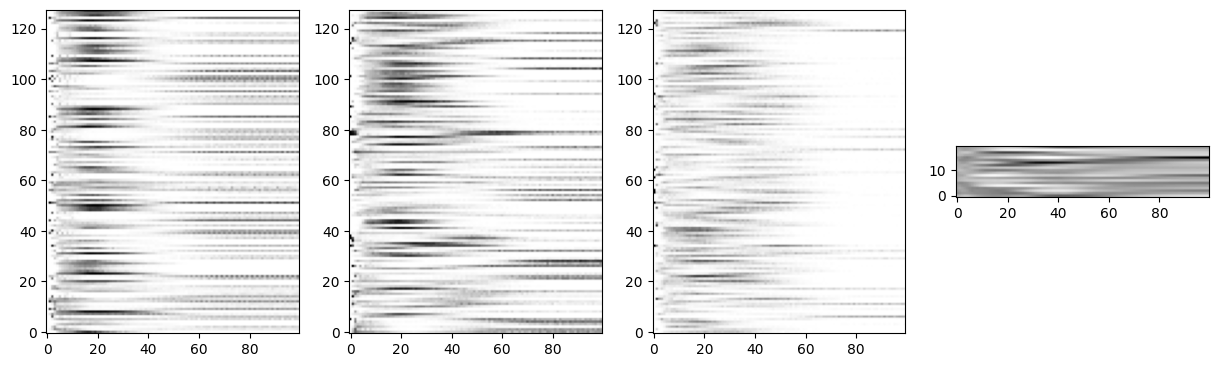

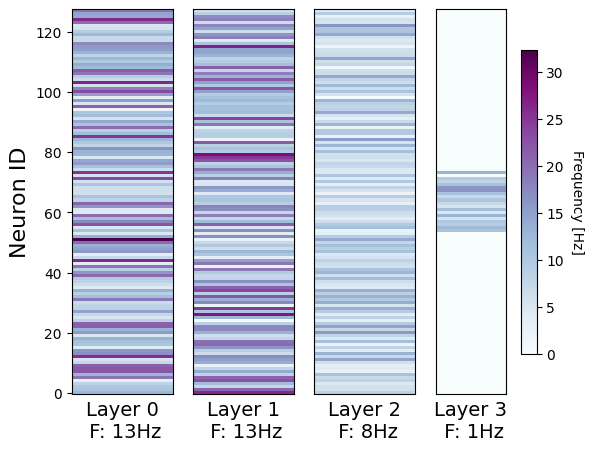

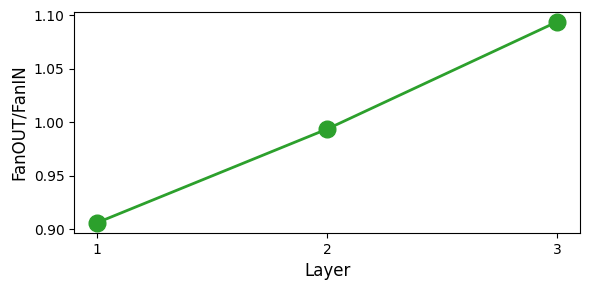

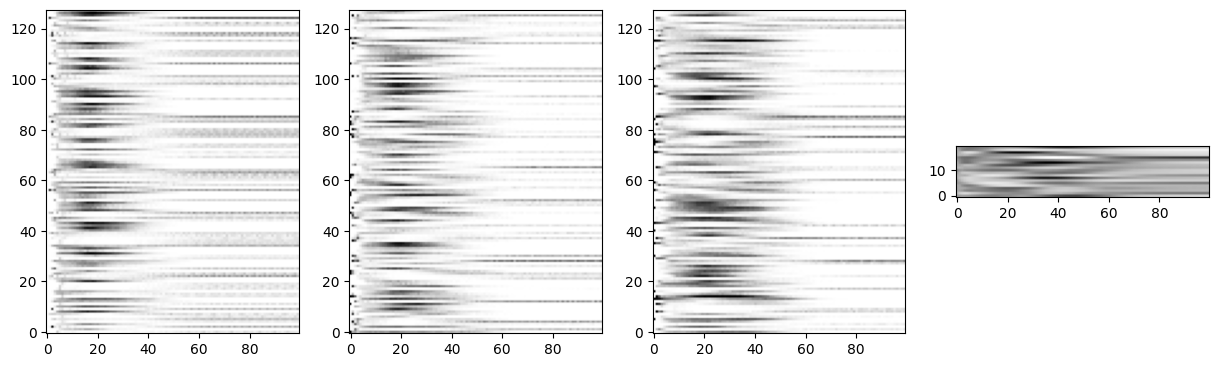

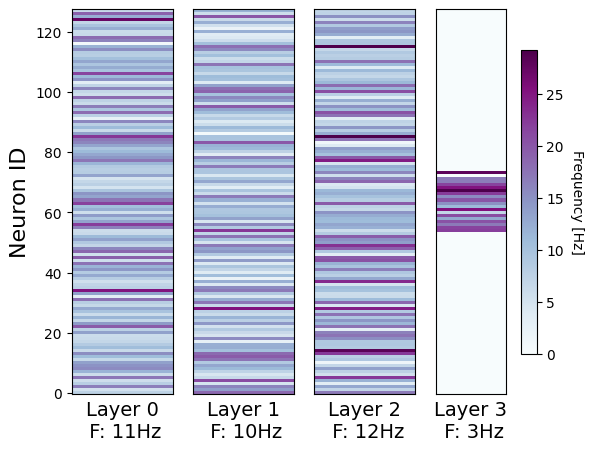

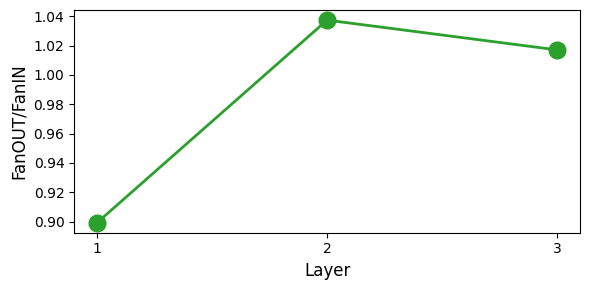

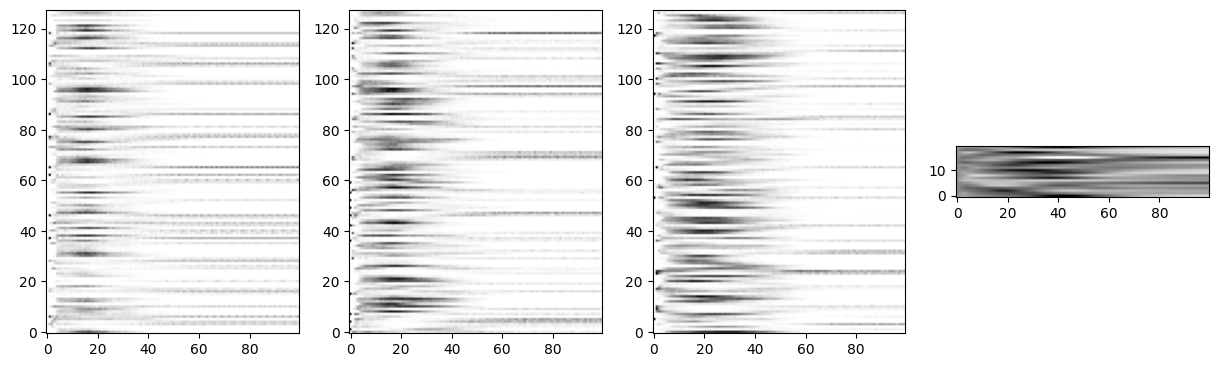

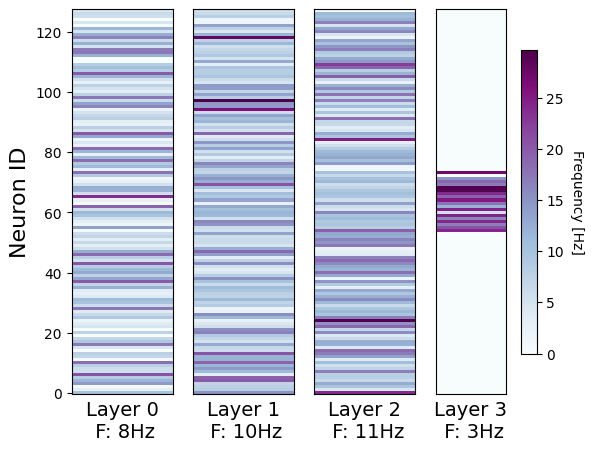

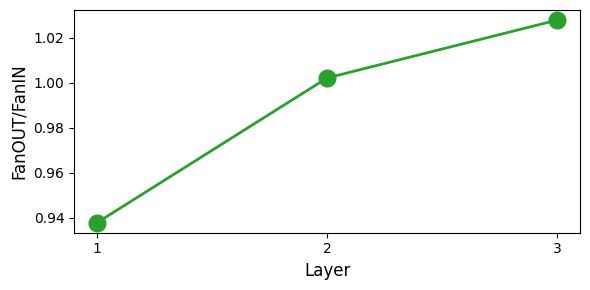

In [251]:
model_paths = ['Hierarchy_tau_mem100_delta_tau-90_seed0', 
               'Hierarchy_tau_mem100_delta_tau0_seed0', 
               'Hierarchy_tau_mem100_delta_tau90_seed0']
spiking_activity_models = []

for m, model_path in enumerate( model_paths ):
    model_name = os.path.join( model_path, 'model.pkl' )
    file_name = os.path.join( dir_models, model_name )
    loaded_model = pickle.load( open( file_name, 'rb' ) )
    out_spike_net = run_inference( loaded_model )

    # Computing Fan-in Fan-out
    FanIN, FanOUT = [], []
    for i in range( args.n_layers-1 ):
        FanIN.append( np.abs( loaded_model['net_params_best'][i][0][0] ).mean(0) )
        FanOUT.append( np.abs( loaded_model['net_params_best'][i+1][0][0] ).mean(1) )
    FanIN = np.array( FanIN ); FanOUT = np.array( FanOUT )

    # collecting the spiking activity
    spiking_activity = []
    for i in range( args.n_layers ):
        # print( f'Layer {i+1}, spiking frequency: {out_spike_net[i].mean()*args.timestep**-1:.2f}Hz' )
        if i == args.n_layers-1:
            mean_spk = 0. #out_spike_net[0].mean( ).reshape(-1,1) *args.timestep**-1
            padded_spikes = np.pad( out_spike_net[i].mean( axis=(0,1) ) + np.abs( out_spike_net[i].mean( axis=(0,1) ).min() ), 
                                pad_width=( int( (args.n_hid-20)/2) ), constant_values=(mean_spk) ).reshape(-1,1)
            padded_spikes = ( padded_spikes / padded_spikes.max() ) * spiking_activity[-1].max()
            spiking_activity.append( padded_spikes )
        else:
            spiking_activity.append( out_spike_net[i].mean( axis=(0,1) ).reshape(-1,1) *args.timestep**-1 )
    spiking_activity = np.hstack( spiking_activity ).T
    spiking_activity_models.append(spiking_activity)

    # Plotting the spiking activity
    fig, ax = plt.subplots( 1, args.n_layers, figsize=( 15,10 ) )
    fig2, ax2 = plt.subplots( 1, args.n_layers, figsize=( 6,5 ) )
    for i in range( args.n_layers ):
        ax[i].imshow( out_spike_net[i].mean( axis=(0) ).T, cmap='Grays', origin='lower' )
        im = ax2[i].imshow( spiking_activity[i].reshape(-1,1), aspect='auto', cmap='BuPu',
                            vmin=0, vmax=spiking_activity.flatten().max(), origin='lower' )
        ax2[i].set_xticks( [] ); ax2[i].set_xlabel(f'Layer {i}\n F: {spiking_activity[i].mean():.0f}Hz', size=14)
        if i != 0: ax2[i].set_yticks([])
        else: ax2[i].set_ylabel( 'Neuron ID', size=16 )
    cbar = fig.colorbar(im, ax=ax2[i], pad=0.15)
    cbar.ax.set_ylabel('Frequency [Hz]', rotation=-90, va="bottom")

    # Plotting the FanIN/FanOUT
    figF, axF = plt.subplots( figsize=(6,3) )
    axF.plot( np.mean(FanOUT/FanIN, axis=1), color='tab:green', marker='o', ms=12, lw=2 )
    axF.set_xticks( np.arange( args.n_layers-1 ), np.arange( args.n_layers-1 )+1 )
    axF.set_ylabel( 'FanOUT/FanIN', size=12 )
    axF.set_xlabel( 'Layer', size=12 )
    
    plt.tight_layout()
    plt.show()

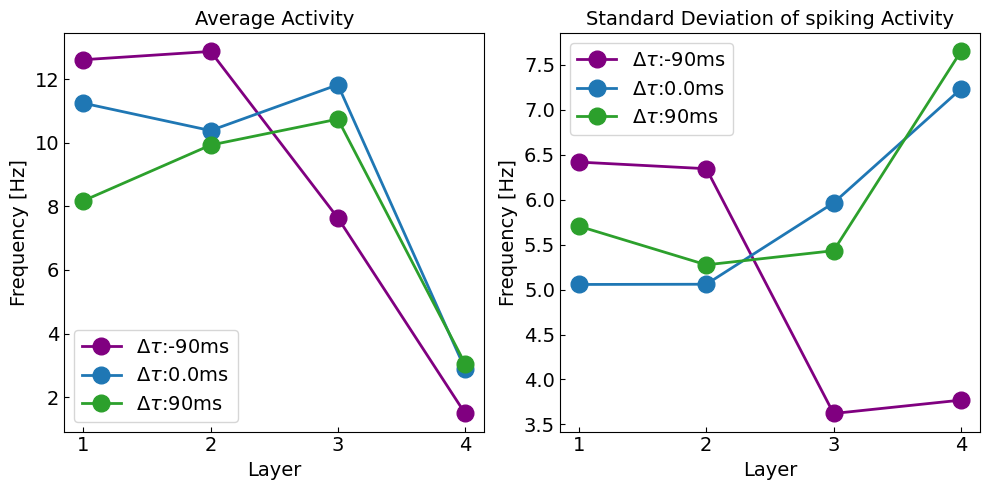

In [211]:
fig_freq, ax = plt.subplots( 1,2, figsize=(10,5) )
# plotting the aerage frequency per layer, for the different models
deltas = [-90, 0., 90]
colors  = ['purple', 'tab:blue', 'tab:green']
for s, spiking_activity in enumerate( spiking_activity_models ):
    ax[0].plot( [spiking_activity[i].mean() for i in range(args.n_layers)], 
                color=colors[s], label=r'$\Delta \tau$:'+str(deltas[s])+'ms',
                marker='o', ms=12, lw=2 )
    ax[1].plot( [spiking_activity[i].std() for i in range(args.n_layers)], 
                color=colors[s], label=r'$\Delta \tau$:'+str(deltas[s])+'ms',
                marker='o', ms=12, lw=2 )
[ax[i].set_xticks( np.arange( args.n_layers ), np.arange( args.n_layers )+1 ) for i in range(len(ax))]
[ax[i].set_xlabel( 'Layer', size=14 ) for i in range(len(ax))]
[ax[i].set_ylabel( 'Frequency [Hz]', size=14 ) for i in range(len(ax))]
[ax[i].legend(prop={'size':14}) for i in range(len(ax))]
[ax[i].tick_params( labelsize=14, direction='in' ) for i in range(len(ax))]
ax[0].set_title( 'Average Activity', size=14 )
ax[1].set_title( 'Standard Deviation of spiking Activity', size=14 )
plt.tight_layout()

In [1]:
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random

from jax import vmap, jit, value_and_grad, local_device_count
from jax.example_libraries import optimizers
from jax.lax import scan, cond
import pickle

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".25" # needed because network is huge
os.environ["CUDA_VISIBLE_DEVICES"]="3"
jax.devices()

from utils_initialization import *
from training import *

I0000 00:00:1714686318.652461       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


### MTS-XOR: analysis on convergence rate with temporal Hierarchy

In [7]:
# Hyperparameter setting
args.train_alpha = False
args.hierarchy_tau = False
args.distrib_tau = 'normal'
args.recurrent = False
args.n_layers = 3
args.n_hid = 10
# time constants
args.tau_mem = 0.3
args.delta_tau = 0.4
args.distrib_tau_sd = 0.1
# LR and regularizers
args.n_epochs = 60
args.verbose = False
# task-specific parameters
args.dataset_name = 'mts_xor'
args.n_in = 40
args.n_out = 2
args.decoder = 'vmem_time'
args.time_max = 1.0 # second
args.timestep = args.time_max/args.nb_steps # second
args.tau_out = 0.05
args.batch_size = 512


# pick 5 seeds and store the initial time constant
seeds = [0,1,2,3,4]
train_loss_list, train_loss_hierarchy_list = [], []
test_accs, test_accs_hierarchy = [], []
for s in seeds:

    print('-- Seed '+str(s))
    args.seed = s

    # Training without hierarchy
    args.hierarchy_tau = False
    train_loss, test_acc, val_acc, net_params_train = train_hsnn( args = args, wandb_flag=False )
    test_accs.append( test_acc )
    train_loss_list.append( train_loss )

    # Training with hierarchy
    args.hierarchy_tau = 'tanh'
    train_loss, test_acc, val_acc, net_params_train = train_hsnn( args = args, wandb_flag=False )
    test_accs_hierarchy.append( test_acc )
    train_loss_hierarchy_list.append( train_loss )

import pickle
dict_tau_F2 = {
    'args' : args, 'seeds' : seeds,
    'train_loss_list' :train_loss_list,
    'train_loss_hierarchy_list' : train_loss_hierarchy_list,
    'test_accs' : test_accs,
    'test_accs_hierarchy' : test_accs_hierarchy,
}
file_save_tau_F2 = './results/F2/Convergence_loss_0205_mts_xor.pkl'
pickle.dump( dict_tau_F2, open( file_save_tau_F2, 'wb' ) )

-- Seed 0
Validation Accuracy: 90.03
Test Accuracy: 89.03
Validation Accuracy: 94.77
Test Accuracy: 94.77
-- Seed 1
Validation Accuracy: 90.80
Test Accuracy: 89.94
Validation Accuracy: 92.85
Test Accuracy: 92.21
-- Seed 2
Validation Accuracy: 90.49
Test Accuracy: 91.14
Validation Accuracy: 92.99
Test Accuracy: 93.34
-- Seed 3
Validation Accuracy: 87.76
Test Accuracy: 88.01
Validation Accuracy: 94.49
Test Accuracy: 94.35
-- Seed 4
Validation Accuracy: 85.86
Test Accuracy: 86.90
Validation Accuracy: 82.41
Test Accuracy: 82.55


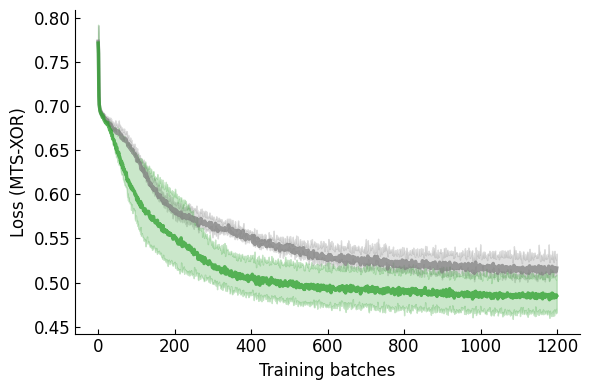

In [9]:
# import the data
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
file_save_tau_F2 = './results/F2/Convergence_loss_0205_mts_xor.pkl'
dict_tau_F2 = pickle.load( open(file_save_tau_F2, 'rb' ) )
train_loss_list = dict_tau_F2['train_loss_list']
train_loss_hierarchy_list = dict_tau_F2['train_loss_hierarchy_list']
test_accs = dict_tau_F2['test_accs']
test_accs_hierarchy = dict_tau_F2['test_accs_hierarchy']

fig, ax = plt.subplots( figsize=(6,4) )
# Without Hierarchy
_ = ax.plot( np.mean(train_loss_list, axis=0), color='gray', ls='-', lw=2.5, alpha=0.75 )
_ = ax.fill_between( np.arange(0, np.array(train_loss_list).shape[1]), 
                    np.quantile(train_loss_list, axis=0, q=0.35), np.quantile(train_loss_list, axis=0, q=0.85), 
                     color='gray', alpha=0.25 )
# With Hierarchy
_ = ax.plot( np.mean(train_loss_hierarchy_list, axis=0), color='tab:green', ls='-', lw=2.5, alpha=0.75 )
_ = ax.fill_between( np.arange(0, np.array(train_loss_hierarchy_list).shape[1]), 
                    np.quantile(train_loss_hierarchy_list, axis=0, q=0.35), np.quantile(train_loss_hierarchy_list, axis=0, q=0.85), 
                     color='tab:green', alpha=0.25 )

ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel( 'Training batches', size=12 )
ax.set_ylabel( 'Loss (MTS-XOR)', size=12 )
ax.tick_params( direction='in', labelsize=12 )

plt.tight_layout()


# Hierarchy found by optimization (Figure 3)
---
here we run a set of two experiments where we train the time constants of SNNs to verify that optimization results in Hierarchy of Time Constants

### SHD - time constant hierarchy emerging from training

In [1]:
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random

from jax import vmap, jit, value_and_grad, local_device_count
from jax.example_libraries import optimizers
from jax.lax import scan, cond
import pickle

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".5" # needed because network is huge
os.environ["CUDA_VISIBLE_DEVICES"]="3"
jax.devices()

from utils_initialization import *
from training import *

I0000 00:00:1719560222.661978       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
# Hyperparameter setting
args.train_alpha = True
args.hierarchy_tau = False
args.distrib_tau = 'normal'
args.recurrent = False
args.n_layers = 6
args.n_hid = 32
# time constants
args.tau_mem = 0.1
args.delta_tau = 0.0
args.distrib_tau_sd = 0.1
# LR and regularizers
args.l2_alpha_sd = 1e-1
args.n_epochs = 40
args.dataset_name = 'shd'
args.decoder = 'cum'
args.n_out = 20 if args.dataset_name == 'shd' else 35  # output channels
args.verbose = False


# pick 5 seeds and store the initial time constant
seeds = [0,1,2,3,4]

time_const_init_list, time_const_train_list = [], []
test_accs = []
for s in seeds:
    print('-- Seed '+str(s))
    args.seed = s
    key = jax.random.PRNGKey(args.seed)
    net_params, _ = params_initializer( key=key, args=args )
    time_const_init_list.append( [net_params[i][1] for i in range(len(net_params)-1)] )

    # Training and collecting the time constants
    train_loss, test_acc, val_acc, net_params_train = train_hsnn( args = args, wandb_flag=False )
    test_accs.append( test_acc )
    time_const_train_list.append( [net_params_train[i][1] for i in range(len(net_params_train)-1)] )

import pickle
dict_tau_F2 = {
    'args' : args, 'seeds' : seeds,
    'time_const_init_list' :time_const_init_list,
    'time_const_train_list' : time_const_train_list,
    'test_accs' : test_accs,
}
file_save_tau_F2 = './results/F3/Tau_analysis_2706_d.pkl'
pickle.dump( dict_tau_F2, open( file_save_tau_F2, 'wb' ) )

-- Seed 0
Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
Validation Accuracy: 94.46
Test Accuracy: 84.77
-- Seed 1
Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
Validation Accuracy: 93.77
Test Accuracy: 85.76
-- Seed 2
Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
Validation Accuracy: 93.04
Test Accuracy: 79.43
-- Seed 3
Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
Validation Accuracy: 93.69
Test Accuracy: 82.00
-- Seed 4
Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
Validation Accuracy: 93.68
Test Accuracy: 79.98


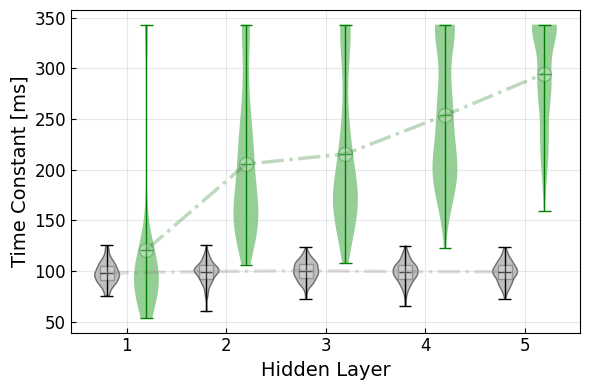

In [5]:
# import the data
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
file_save_tau_F2 = './results/F3/Tau_analysis_2706_b.pkl'
dict_tau_F2 = pickle.load( open(file_save_tau_F2, 'rb' ) )
args = dict_tau_F2['args']; seeds = dict_tau_F2['seeds']
time_const_init_list = dict_tau_F2['time_const_init_list']
time_const_train_list = dict_tau_F2['time_const_train_list']
test_accs = dict_tau_F2['test_accs' ]

fig, ax = plt.subplots( figsize=(6,4) )

# Initialized taus
ds_init  = np.clip( np.hstack( time_const_init_list ), 0, 1.0-4e-2)
ds_init  = - 1e3 * args.timestep / np.log( ds_init )
violin_init = ax.violinplot( list(ds_init), positions=np.arange( args.n_layers-1 )-0.2,
                    widths=0.25, showmeans=True )
_ = ax.plot( np.arange( args.n_layers-1 )-0.2, ds_init.mean( axis=-1 ),
            color='gray', marker = 's', markeredgecolor='k', ls='-.',
            markerfacecolor='white', lw=2.5, alpha=0.25, ms=10 )

for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = violin_init[partname]; vp.set_edgecolor('k');vp.set_linewidth(1)
for pc in violin_init['bodies']:
    pc.set_facecolor('gray');pc.set_edgecolor('black');pc.set_alpha(0.5)

# Optimized taus
ds_train = np.clip( np.hstack( time_const_train_list ), 0, 1.0-4e-2)
ds_train = - 1e3 * args.timestep / np.log( ds_train )
violin_train = ax.violinplot( list(ds_train), positions=np.arange( args.n_layers-1 )+0.2,
                    widths=0.25, showmeans=True, showextrema=True )
_ = ax.plot( np.arange( args.n_layers-1 )+0.2, np.mean(ds_train, axis=-1 ),
            color='darkgreen', marker = 'o', markeredgecolor='darkgreen', ls='-.',
            markerfacecolor='white', lw=2.5, alpha=0.25, ms=10 )
# ax.set_yscale('log')
ax.set_xlabel( 'Hidden Layer', size=14 )
ax.set_ylabel( 'Time Constant [ms]', size=14 )
ax.tick_params( direction='in', labelsize=12 )
ax.set_xticks( np.arange( args.n_layers-1 ), np.arange( args.n_layers-1 )+1 )
# ax.legend(prop={'size':14})
ax.grid(alpha=0.3)

for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = violin_train[partname];vp.set_edgecolor('green');vp.set_linewidth(1)
for pc in violin_train['bodies']:
    pc.set_facecolor('tab:green');pc.set_alpha(0.5)

plt.tight_layout()
file_save_F2_tau = f'./results/F3/Tau_analysis_{args.n_layers}.pdf'
# fig.savefig( file_save_F2_tau, dpi = 300, transparent=False )

### MTS-XOR - time constant hierarchy emerging from training

In [2]:
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random

from jax import vmap, jit, value_and_grad, local_device_count
from jax.example_libraries import optimizers
from jax.lax import scan, cond
import pickle

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".25" # needed because network is huge
os.environ["CUDA_VISIBLE_DEVICES"]="3"
jax.devices()

from utils_initialization import *
from training import *

I0000 00:00:1719559665.449578       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [3]:
# Hyperparameter setting
args.train_alpha = True
args.hierarchy_tau = False
args.distrib_tau = 'normal'
args.recurrent = False
args.n_layers = 4
args.n_hid = 32 #10
# time constants
args.tau_mem = 0.2
args.delta_tau = 0.0
args.distrib_tau_sd = 0.1
# LR and regularizers
args.l2_alpha_sd = 1e-3
args.n_epochs = 60
args.verbose = False
# task-specific parameters
args.dataset_name = 'mts_xor'
args.n_in = 40
args.n_out = 2
args.decoder = 'vmem_time'
args.time_max = 1.0 # second
args.timestep = args.time_max/args.nb_steps # second
args.tau_out = 0.05
args.distrib_tau_sd = 0.0
args.batch_size = 512


# pick 5 seeds and store the initial time constant
seeds = [0,1,2,3,4]

time_const_init_list, time_const_train_list = [], []
test_accs = []
for s in seeds:

    print('-- Seed '+str(s))
    args.seed = s
    key = jax.random.PRNGKey(args.seed)
    net_params, _ = params_initializer( key=key, args=args )
    time_const_init_list.append( [net_params[i][1] for i in range(len(net_params)-1)] )

    # Training and collecting the time constants
    train_loss, test_acc, val_acc, net_params_train = train_hsnn( args = args, wandb_flag=False )
    test_accs.append( test_acc )
    time_const_train_list.append( [net_params_train[i][1] for i in range(len(net_params_train)-1)] )

import pickle
dict_tau_F2 = {
    'args' : args, 'seeds' : seeds,
    'time_const_init_list' :time_const_init_list,
    'time_const_train_list' : time_const_train_list,
    'test_accs' : test_accs,
}
file_save_tau_F2 = './results/F3/Tau_analysis_2706_e_mts_xor.pkl'
pickle.dump( dict_tau_F2, open( file_save_tau_F2, 'wb' ) )

-- Seed 0
Validation Accuracy: 99.23
Test Accuracy: 99.19
-- Seed 1
Validation Accuracy: 99.30
Test Accuracy: 99.20
-- Seed 2
Validation Accuracy: 99.06
Test Accuracy: 99.05
-- Seed 3
Validation Accuracy: 99.23
Test Accuracy: 99.31
-- Seed 4
Validation Accuracy: 99.25
Test Accuracy: 99.28


/var/folders/gr/cpg6p4_95b3fghclqyk0n2d00000gn/T/ipykernel_70843/3116223572.py:24: RuntimeWarning: divide by zero encountered in log
  ds_train = - 1e3 * args.timestep / np.log( ds_train )


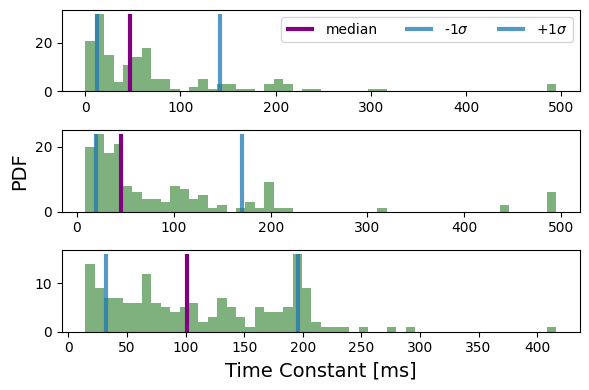

In [5]:
# import the data
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
file_save_tau_F2 = './results/F3/Tau_analysis_2706_e_mts_xor.pkl'
dict_tau_F2 = pickle.load( open(file_save_tau_F2, 'rb' ) )
args = dict_tau_F2['args']; seeds = dict_tau_F2['seeds']
time_const_init_list = dict_tau_F2['time_const_init_list']
time_const_train_list = dict_tau_F2['time_const_train_list']
test_accs = dict_tau_F2['test_accs' ]


# Initialized taus
ds_init  = np.clip( np.hstack( time_const_init_list ), 0, 1.0-2e-2)
ds_init  = - 1e3 * args.timestep / np.log( ds_init )

fig, ax = plt.subplots( ds_init.shape[0],1, figsize=(6,4) )
# for i in range(ds_init.shape[0]):
#     _ = ax[i].hist( ds_init[i], 50, color='k', density=True, alpha=1 )

# Optimized taus
ds_train = np.clip( np.hstack( time_const_train_list ), 0, 1.0-2e-2)
ds_train = - 1e3 * args.timestep / np.log( ds_train )
for i in range(ds_init.shape[0]):
    [n, bins, patches] = ax[i].hist( ds_train[i], 50, color='darkgreen', density=False, alpha=0.5 )
    _ = ax[i].vlines( np.quantile( ds_train[i], q=0.5 ), 0, np.max(n), color='purple', lw=3, alpha=1, label='median' )
    _ = ax[i].vlines( np.quantile( ds_train[i], q=0.15 ), 0, np.max(n), color='tab:blue', lw=3, alpha=0.75, label=r'-1$\sigma$' )
    _ = ax[i].vlines( np.quantile( ds_train[i], q=0.85 ), 0, np.max(n), color='tab:blue', lw=3, alpha=0.75, label=r'+1$\sigma$' )
    # _ = ax[0].hist( ds_train[i], 50, density=False, alpha=0.5 )

# ax.set_yscale('log')
ax[1].set_ylabel( 'PDF', size=14 )
ax[-1].set_xlabel( 'Time Constant [ms]', size=14 )
ax[0].legend( ncols=3 )
# ax[-1].tick_params( direction='in', labelsize=12 )
# [ ax[i].set_xticks( np.arange( args.n_layers-1 ), np.arange( args.n_layers-1 )+1 )
#  for i in range(ds_init.shape[0]) ]
# ax.legend(prop={'size':14})
# ax.grid(alpha=0.3)

plt.tight_layout()
file_save_F2_tau = f'./results/F3/Tau_analysis_{args.n_layers}_PDF.pdf'
# fig.savefig( file_save_F2_tau, dpi = 300, transparent=False )

# Gradient Checks
---
In here we look at the magniude of the gradients, for SNNs with and without hierarhcy. Note that we aim at looking at the gradients per time-step.

From theory, we expect that the gradients shapes are different with and without hierarchy. In particular, Hierarchy should allow for multiple smooth pathways in the loss landscape to recover information from the past.

In [1]:
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random

from jax import vmap, jit, value_and_grad, local_device_count
from jax.example_libraries import optimizers
from jax.lax import scan, cond
import pickle

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".25" # needed because network is huge
os.environ["CUDA_VISIBLE_DEVICES"]="3"
jax.devices()

from utils_initialization import *
from training import *

In [16]:
# Hyperparameter setting
args.train_alpha = True
args.hierarchy_tau = 'linear'
args.distrib_tau = 'normal'
args.recurrent = False
args.n_layers = 3
args.n_hid = 10
# time constants
args.tau_mem = 0.2
args.delta_tau = -0.3
args.distrib_tau_sd = 0.1
# LR and regularizers
args.l2_alpha_sd = 1e-3
args.n_epochs = 60
args.verbose = False
# task-specific parameters
args.dataset_name = 'mts_xor'
args.n_in = 10 #40
args.n_out = 2
args.decoder = 'vmem_time'
args.time_max = 1.0 # second
args.timestep = args.time_max/args.nb_steps # second
args.tau_out = 0.05
args.distrib_tau_sd = 0.0
args.batch_size = 512

In [13]:
### from the training function
train_dl, val_dl, test_dl = get_dataloader( args=args, verbose=True )

# Layer and Layer out could be different in general (output might not be spiking)
# so the two following function scan the lyers and jit for speed
@jit
def scan_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer = vmap( scan_layer, in_axes=(None, 0))

@jit
def scan_out_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer_out, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer_out = vmap( scan_out_layer, in_axes=(None, 0))

# the following function implements the main network
@partial(jax.jit, static_argnames=['dilation', 'dilation_delta'])
def hsnn( args_in, input_spikes, dilation=5, dilation_delta=0 ):
    net_params, net_states, key, dropout_rate = args_in # input arguments
    n_layers = len( net_params )                        # number of layers
    # collection of output spikes
    out_spike_net = [] # collects the spikes from each layer
    # Loop over the layers
    for l in range(n_layers):
        # selecting the right input (from the previous layer)
        if l == 0: layer_input_spike = input_spikes
        else: layer_input_spike = out_spikes_layer
        # making layers' params and states explitic
        # parameters (weights and alpha) and the state of the neurons (spikes, inputs and membrane, ecc..)
        w, alpha = net_params[l]; #w_mask, tau, V_mem, out_spikes, v_thr, dilation_layer = net_states[l]
        if len(w) == 3: # it means that we'll do normalization
            weight, scale, bias = w
        else: weight = w
        if len(weight) ==2: weight, _ = weight
        # Multiplying the weights by the spikes
        if len( weight.shape ) == 3 and l!=(n_layers-1): 
            dilation_layer = int( np.clip(dilation + ((n_layers-2)**-1)*(l-(n_layers-2)/2)*dilation_delta, 0, None ) )
            I_in = Conv1D_causal(layer_input_spike, weight, dilation=dilation_layer) #(l+1)*5 dilation_lay[l]
        else: I_in = jnp.matmul(layer_input_spike, weight)

        # Normalization (if selected)
        if len(w) == 3: # it means that we'll do normalization
            b, t, n = I_in.shape
            I_in = norm( I_in.reshape( b*t, n ), bias = bias, scale = scale )
            I_in = I_in.reshape( b,t,n ) # normalized input current
        # Forward pass of the Layer
        args_in_layer = [net_params[l], net_states[l]]
        if l+1 == n_layers:
            _, out_spikes_layer = vscan_layer_out( args_in_layer, I_in )
        else: 
            _, out_spikes_layer = vscan_layer( args_in_layer, I_in )
            # Dropout
            key, key_dropout = jax.random.split(key, 2)
            out_spikes_layer = dropout( key_dropout, out_spikes_layer, rate=dropout_rate, deterministic=False )
        out_spike_net.append(out_spikes_layer)
    return out_spikes_layer, out_spike_net

decoder_dict = {'cum'  : decoder_cum,
                'sum'  : decoder_sum,
                'vmax' : decoder_vmax,
                'vlast': decoder_vlast,
                'freq' : decoder_freq,
                'vmem_time' : decoder_vmem_time,
                }
if args.decoder in decoder_dict.keys():
    decoder = decoder_dict[args.decoder]
elif args.dataset_name == 'mts_xor':
    decoder = decoder_vmem_time
else: 
    print('Unrecognized Decoder, will revert to a "cum"-style decoder')
    print('Next time choose a decoder in: '+str(list(decoder_dict.keys())))
    args.decoder = 'cum'
    decoder = decoder_dict[args.decoder]

# network architecture
if args.recurrent:
    layer = rlif_step
else: 
    layer = lif_step
if args.decoder == 'freq':
    layer_out = lif_step
else: 
    layer_out = li_step
if args.normalizer == 'batch': norm = BatchNorm
elif args.normalizer == 'layer': norm = LayerNorm
else: norm = None

def loss(key, net_params, net_states, X, Y, epoch, dropout_rate=0.0, dilation=5, dilation_delta=0):
    """ Calculates CE loss after predictions. """

    # we might want to add noise in the forward pass --> memristor-aware-training
    # weight = [net_params[i][0] for i in range( len(net_params) )]
    # weight = cond(
    #     epoch >= noise_start_step, 
    #     lambda weight, key : add_noise(weight, key, noise_std),
    #     lambda weight, key : weight,
    #     weight, key
    # )
    # Forward pass throught the whole model
    args_in = [net_params, net_states, key, dropout_rate]
    output_layer, out_spike_net = hsnn( args_in, X, dilation, dilation_delta )
    Yhat = decoder( output_layer )
    # compute the loss and correct examples
    num_correct = jnp.sum(jnp.equal(jnp.argmax(Yhat, -1), jnp.argmax(Y, -1)))
    # cross entropy loss
    loss_ce = -jnp.mean( jnp.sum(Y * jnp.log(Yhat+1e-12), axis=-1) )
    # L2 norm
    loss_l2 = optimizers.l2_norm( [net_params[l][0] for l in range(len(net_params))] ) * args.l2_lambda
    # firing rate loss
    avg_spikes_neuron = jnp.mean( jnp.stack( [ jnp.mean( jnp.sum( out_spike_net[l], axis=1 ), axis=(0,-1) ) for l in range( len(net_params)-1 )] ) )
    loss_fr = args.freq_lambda * (args.target_fr - avg_spikes_neuron)**2
    # loss on the decaying factor
    loss_alpha = optimizers.l2_norm( [jax.nn.relu(net_params[l][1]-1.+5e-2) for l in range(len(net_params))] ) * 1e-1
    loss_alpha_sd = optimizers.l2_norm( [(net_params[l][1]-jnp.mean(net_params[l][1])) for l in range(len(net_params))] ) * args.l2_alpha_sd
    # Total loss
    loss_total = loss_ce + loss_l2 + loss_fr + loss_alpha + loss_alpha_sd
    loss_values = [num_correct, loss_ce]
    return loss_total, loss_values

def one_hot(x, n_class):
    if args.dataset_name == 'mts_xor':
        return jnp.array(x[:,:, None] == jnp.arange(n_class), dtype=jnp.float32)
    else:
        return jnp.array(x[:, None] == jnp.arange(n_class), dtype=jnp.float32)
    
# LR decay
if args.lr_decay_every + args.lr_start_decay < args.n_epochs:
    k = int( (args.n_epochs - args.lr_start_decay) // args.lr_decay_every + 1 )
    lr_decay = np.clip( args.lr_decay, 0, 1 )
    # intervals = [ i*args.lr_decay_every for i in range(int((args.n_epochs)/args.lr_decay_every)-1) ]
    # lr_values = [args.lr*(lr_decay)**i for i in range(int(args.n_epochs/args.lr_decay_every))]
    intervals = [args.lr_start_decay] + [ args.lr_start_decay+i*args.lr_decay_every for i in range(1,k) ]
    lr_values = [args.lr]+[ args.lr*(lr_decay)**(i+1) for i in range(k) ]
    pw_lr = optimizers.piecewise_constant(intervals, lr_values)
else: pw_lr = optimizers.piecewise_constant([args.n_epochs], [args.lr, args.lr*np.clip( args.lr_decay, 1e-5, 1 )])

In [17]:
original_nb_steps = 100 #args.nb_steps

grads_hist = []
grads_hist_l1 = []
grads_hist_l2 = []
grads_hist_l3 = []
for t in range( 15, original_nb_steps, 5 ):

    # Randon Number Generator
    key = jax.random.PRNGKey(args.seed)
    key, key_model = jax.random.split(key, 2)

    # define the optimizer --> In this experiment we choose SGD
    opt_init, opt_update, get_params = optimizers.sgd(step_size=pw_lr)

    # initialize the parameters (and states)
    net_params, net_states = params_initializer( key_model, args )
    opt_state = opt_init(net_params)
    train_params = get_params(opt_state)

    # draw a batch of data
    args.nb_steps = t
    x,y = next(iter(train_dl))
    y = one_hot(y, args.n_out)

    # forward pass and compute the gradients
    value, grads = value_and_grad(loss, has_aux=True, argnums=(1))(key, train_params, net_states, x[:,:t], y[:,:t], 0, dropout_rate=0, dilation=0, dilation_delta=0)

    # collect the gradients through time
    grads_hist.append(grads)
    if t == 15:
        grads_hist_l1.append( grads[0][0][0] )
        grads_hist_l2.append( grads[1][0][0] )
        grads_hist_l3.append( grads[2][0][0] )
    else: 
        grads_hist_l1.append( grads[0][0][0] - grads_hist_l1[-1] )
        grads_hist_l2.append( grads[1][0][0] - grads_hist_l2[-1] )
        grads_hist_l3.append( grads[2][0][0] - grads_hist_l3[-1] )

Mean W1, Std W1: 0.022579237818717957, 0.17069487273693085
Mean W1, Std W1: -0.004483379423618317, 0.12764954566955566
Mean W1, Std W1: -0.002054900396615267, 0.14321193099021912


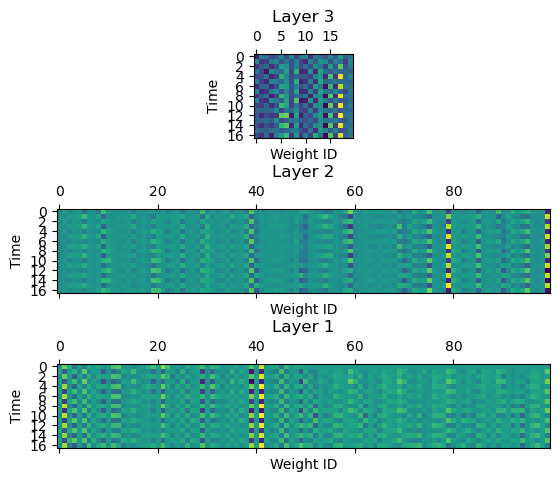

In [11]:
fig, ax = plt.subplots( 3, 1 )
t_dim = np.array( grads_hist_l3 ).shape[0]

# Layer 3
ax[0].matshow( np.array( grads_hist_l3 ).reshape( t_dim, -1 ) )
ax[0].set_ylabel( 'Time' )
ax[0].set_xlabel( 'Weight ID' )
ax[0].set_title( 'Layer 3' )
mean_W3, std_W3 = np.array( grads_hist_l3 ).reshape( t_dim, -1 ).mean(), np.array( grads_hist_l3 ).reshape( t_dim, -1 ).std()
print( f'Mean W1, Std W1: {mean_W3}, {std_W3}' )

# Layer 2
ax[1].matshow( np.array( grads_hist_l2 ).reshape( t_dim, -1 ) )
ax[1].set_ylabel( 'Time' )
ax[1].set_xlabel( 'Weight ID' )
ax[1].set_title( 'Layer 2' )
mean_W2, std_W2 = np.array( grads_hist_l2 ).reshape( t_dim, -1 ).mean(), np.array( grads_hist_l2 ).reshape( t_dim, -1 ).std()
print( f'Mean W1, Std W1: {mean_W2}, {std_W2}' )

# Layer 1
ax[2].matshow( np.array( grads_hist_l1 ).reshape( t_dim, -1 ) )
ax[2].set_ylabel( 'Time' )
ax[2].set_xlabel( 'Weight ID' )
ax[2].set_title( 'Layer 1' )
mean_W1, std_W1 = np.array( grads_hist_l1 ).reshape( t_dim, -1 ).mean(), np.array( grads_hist_l1 ).reshape( t_dim, -1 ).std()
print( f'Mean W1, Std W1: {mean_W1}, {std_W1}' )

plt.tight_layout()

Mean W1, Std W1: 0.027390141040086746, 0.18028150498867035
Mean W1, Std W1: -0.0030326838605105877, 0.08535653352737427
Mean W1, Std W1: -0.003760256804525852, 0.14077280461788177


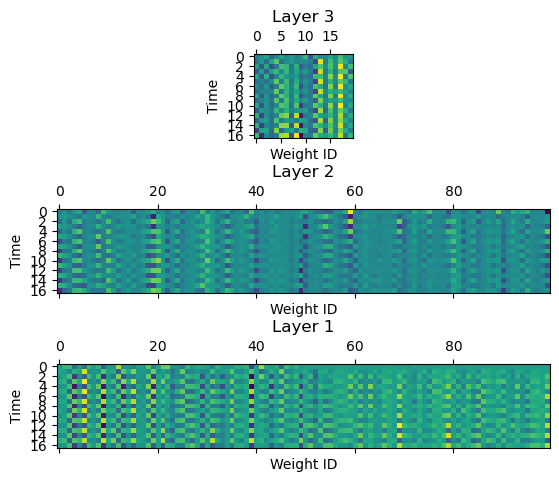

In [15]:
fig, ax = plt.subplots( 3, 1 )
t_dim = np.array( grads_hist_l3 ).shape[0]

# Layer 3
ax[0].matshow( np.array( grads_hist_l3 ).reshape( t_dim, -1 ) )
ax[0].set_ylabel( 'Time' )
ax[0].set_xlabel( 'Weight ID' )
ax[0].set_title( 'Layer 3' )
mean_W3, std_W3 = np.array( grads_hist_l3 ).reshape( t_dim, -1 ).mean(), np.array( grads_hist_l3 ).reshape( t_dim, -1 ).std()
print( f'Mean W1, Std W1: {mean_W3}, {std_W3}' )

# Layer 2
ax[1].matshow( np.array( grads_hist_l2 ).reshape( t_dim, -1 ) )
ax[1].set_ylabel( 'Time' )
ax[1].set_xlabel( 'Weight ID' )
ax[1].set_title( 'Layer 2' )
mean_W2, std_W2 = np.array( grads_hist_l2 ).reshape( t_dim, -1 ).mean(), np.array( grads_hist_l2 ).reshape( t_dim, -1 ).std()
print( f'Mean W1, Std W1: {mean_W2}, {std_W2}' )

# Layer 1
ax[2].matshow( np.array( grads_hist_l1 ).reshape( t_dim, -1 ) )
ax[2].set_ylabel( 'Time' )
ax[2].set_xlabel( 'Weight ID' )
ax[2].set_title( 'Layer 1' )
mean_W1, std_W1 = np.array( grads_hist_l1 ).reshape( t_dim, -1 ).mean(), np.array( grads_hist_l1 ).reshape( t_dim, -1 ).std()
print( f'Mean W1, Std W1: {mean_W1}, {std_W1}' )

plt.tight_layout()

Mean W1, Std W1: 0.021586721763014793, 0.1978255659341812
Mean W1, Std W1: -0.0022694312501698732, 0.10189726203680038
Mean W1, Std W1: -0.0028921503107994795, 0.09526383131742477


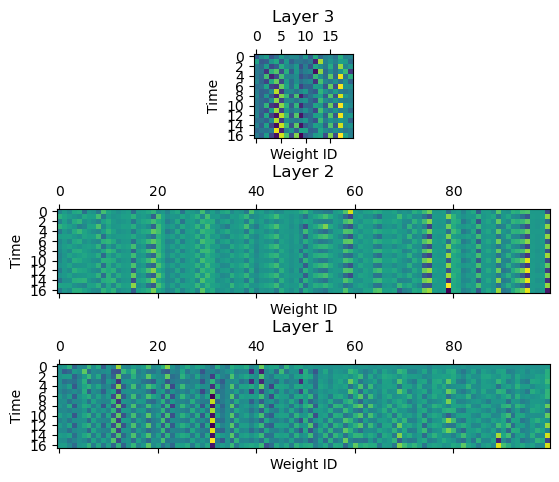

In [18]:
fig, ax = plt.subplots( 3, 1 )
t_dim = np.array( grads_hist_l3 ).shape[0]

# Layer 3
ax[0].matshow( np.array( grads_hist_l3 ).reshape( t_dim, -1 ) )
ax[0].set_ylabel( 'Time' )
ax[0].set_xlabel( 'Weight ID' )
ax[0].set_title( 'Layer 3' )
mean_W3, std_W3 = np.array( grads_hist_l3 ).reshape( t_dim, -1 ).mean(), np.array( grads_hist_l3 ).reshape( t_dim, -1 ).std()
print( f'Mean W1, Std W1: {mean_W3}, {std_W3}' )

# Layer 2
ax[1].matshow( np.array( grads_hist_l2 ).reshape( t_dim, -1 ) )
ax[1].set_ylabel( 'Time' )
ax[1].set_xlabel( 'Weight ID' )
ax[1].set_title( 'Layer 2' )
mean_W2, std_W2 = np.array( grads_hist_l2 ).reshape( t_dim, -1 ).mean(), np.array( grads_hist_l2 ).reshape( t_dim, -1 ).std()
print( f'Mean W1, Std W1: {mean_W2}, {std_W2}' )

# Layer 1
ax[2].matshow( np.array( grads_hist_l1 ).reshape( t_dim, -1 ) )
ax[2].set_ylabel( 'Time' )
ax[2].set_xlabel( 'Weight ID' )
ax[2].set_title( 'Layer 1' )
mean_W1, std_W1 = np.array( grads_hist_l1 ).reshape( t_dim, -1 ).mean(), np.array( grads_hist_l1 ).reshape( t_dim, -1 ).std()
print( f'Mean W1, Std W1: {mean_W1}, {std_W1}' )

plt.tight_layout()

### Gradients on the sMNIST task

In [1]:
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random

from jax import vmap, jit, value_and_grad, local_device_count
from jax.example_libraries import optimizers
from jax.lax import scan, cond
import pickle

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".75" # needed because network is huge
os.environ["CUDA_VISIBLE_DEVICES"]="3"
jax.devices()

from utils_initialization import *
from training import *

In [27]:
# Hyperparameter setting
args.train_alpha = False
args.hierarchy_tau = 'linear'
args.distrib_tau = 'normal'
args.recurrent = False
args.n_layers = 3
args.n_hid = 64
args.seed = 0
# LR and regularizers
args.l2_alpha_sd = 1e-3
args.n_epochs = 60
args.verbose = False
# task-specific parameters
args.dataset_name = 's-mnist'
args.decoder = 'cum'
args.nb_steps               = 28*28
args.n_in                   = 1
args.n_out                  = 10
args.n_hid                  = 128
args.timestep               = 1/args.nb_steps # s
args.tau_mem                = 50*args.timestep
args.delta_tau              = 0.0
args.tau_out                = 200*args.timestep
args.dropout                = 0.1
args.lr                     = 0.01
args.batch_size             = 256
args.hierarchy_conv         = 'kernel'

In [3]:
# Layer and Layer out could be different in general (output might not be spiking)
# so the two following function scan the lyers and jit for speed
@jit
def scan_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer = vmap( scan_layer, in_axes=(None, 0))

@jit
def scan_out_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer_out, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer_out = vmap( scan_out_layer, in_axes=(None, 0))

# the following function implements the main network
@partial(jax.jit, static_argnames=['dilation', 'dilation_delta'])
def hsnn( args_in, input_spikes, dilation=5, dilation_delta=0 ):
    net_params, net_states, key, dropout_rate = args_in # input arguments
    n_layers = len( net_params )                        # number of layers
    # collection of output spikes
    out_spike_net = [] # collects the spikes from each layer
    # Loop over the layers
    for l in range(n_layers):
        # selecting the right input (from the previous layer)
        if l == 0: layer_input_spike = input_spikes
        else: layer_input_spike = out_spikes_layer
        # making layers' params and states explitic
        # parameters (weights and alpha) and the state of the neurons (spikes, inputs and membrane, ecc..)
        w, alpha = net_params[l]; #w_mask, tau, V_mem, out_spikes, v_thr, dilation_layer = net_states[l]
        if len(w) == 3: # it means that we'll do normalization
            weight, scale, bias = w
        else: weight = w
        if len(weight) ==2: weight, _ = weight
        # Multiplying the weights by the spikes
        if len( weight.shape ) == 3 and l!=(n_layers-1): 
            dilation_layer = int( np.clip(dilation + ((n_layers-2)**-1)*(l-(n_layers-2)/2)*dilation_delta, 0, None ) )
            I_in = Conv1D_causal(layer_input_spike, weight, dilation=dilation_layer) #(l+1)*5 dilation_lay[l]
        else: I_in = jnp.matmul(layer_input_spike, weight)

        # Normalization (if selected)
        if len(w) == 3: # it means that we'll do normalization
            b, t, n = I_in.shape
            I_in = norm( I_in.reshape( b*t, n ), bias = bias, scale = scale )
            I_in = I_in.reshape( b,t,n ) # normalized input current
        # Forward pass of the Layer
        args_in_layer = [net_params[l], net_states[l]]
        if l+1 == n_layers:
            _, out_spikes_layer = vscan_layer_out( args_in_layer, I_in )
        else: 
            _, out_spikes_layer = vscan_layer( args_in_layer, I_in )
            # Dropout
            key, key_dropout = jax.random.split(key, 2)
            out_spikes_layer = dropout( key_dropout, out_spikes_layer, rate=dropout_rate, deterministic=False )
        out_spike_net.append(out_spikes_layer)
    return out_spikes_layer, out_spike_net

decoder_dict = {'cum'  : decoder_cum,
                'sum'  : decoder_sum,
                'vmax' : decoder_vmax,
                'vlast': decoder_vlast,
                'freq' : decoder_freq,
                'vmem_time' : decoder_vmem_time,
                }
if args.decoder in decoder_dict.keys():
    decoder = decoder_dict[args.decoder]
elif args.dataset_name == 'mts_xor':
    decoder = decoder_vmem_time
else: 
    print('Unrecognized Decoder, will revert to a "cum"-style decoder')
    print('Next time choose a decoder in: '+str(list(decoder_dict.keys())))
    args.decoder = 'cum'
    decoder = decoder_dict[args.decoder]

# network architecture
if args.recurrent:
    layer = rlif_step
else: 
    layer = lif_step
if args.decoder == 'freq':
    layer_out = lif_step
else: 
    layer_out = li_step
if args.normalizer == 'batch': norm = BatchNorm
elif args.normalizer == 'layer': norm = LayerNorm
else: norm = None

def loss(key, net_params, net_states, X, Y, epoch, dropout_rate=0.0, dilation=5, dilation_delta=0):
    """ Calculates CE loss after predictions. """

    # we might want to add noise in the forward pass --> memristor-aware-training
    # weight = [net_params[i][0] for i in range( len(net_params) )]
    # weight = cond(
    #     epoch >= noise_start_step, 
    #     lambda weight, key : add_noise(weight, key, noise_std),
    #     lambda weight, key : weight,
    #     weight, key
    # )
    # Forward pass throught the whole model
    args_in = [net_params, net_states, key, dropout_rate]
    output_layer, out_spike_net = hsnn( args_in, X, dilation, dilation_delta )
    Yhat = decoder( output_layer )
    # compute the loss and correct examples
    num_correct = jnp.sum(jnp.equal(jnp.argmax(Yhat, -1), jnp.argmax(Y, -1)))
    # cross entropy loss
    loss_ce = -jnp.mean( jnp.sum(Y * jnp.log(Yhat+1e-12), axis=-1) )
    # L2 norm
    loss_l2 = optimizers.l2_norm( [net_params[l][0] for l in range(len(net_params))] ) * args.l2_lambda
    # firing rate loss
    avg_spikes_neuron = jnp.mean( jnp.stack( [ jnp.mean( jnp.sum( out_spike_net[l], axis=1 ), axis=(0,-1) ) for l in range( len(net_params)-1 )] ) )
    loss_fr = args.freq_lambda * (args.target_fr - avg_spikes_neuron)**2
    # loss on the decaying factor
    loss_alpha = optimizers.l2_norm( [jax.nn.relu(net_params[l][1]-1.+5e-2) for l in range(len(net_params))] ) * 1e-1
    loss_alpha_sd = optimizers.l2_norm( [(net_params[l][1]-jnp.mean(net_params[l][1])) for l in range(len(net_params))] ) * args.l2_alpha_sd
    # Total loss
    loss_total = loss_ce + loss_l2 + loss_fr + loss_alpha + loss_alpha_sd
    loss_values = [num_correct, loss_ce]
    return loss_total, loss_values

def one_hot(x, n_class):
    if args.dataset_name == 'mts_xor':
        return jnp.array(x[:,:, None] == jnp.arange(n_class), dtype=jnp.float32)
    else:
        return jnp.array(x[:, None] == jnp.arange(n_class), dtype=jnp.float32)
    
# LR decay
if args.lr_decay_every + args.lr_start_decay < args.n_epochs:
    k = int( (args.n_epochs - args.lr_start_decay) // args.lr_decay_every + 1 )
    lr_decay = np.clip( args.lr_decay, 0, 1 )
    # intervals = [ i*args.lr_decay_every for i in range(int((args.n_epochs)/args.lr_decay_every)-1) ]
    # lr_values = [args.lr*(lr_decay)**i for i in range(int(args.n_epochs/args.lr_decay_every))]
    intervals = [args.lr_start_decay] + [ args.lr_start_decay+i*args.lr_decay_every for i in range(1,k) ]
    lr_values = [args.lr]+[ args.lr*(lr_decay)**(i+1) for i in range(k) ]
    pw_lr = optimizers.piecewise_constant(intervals, lr_values)
else: pw_lr = optimizers.piecewise_constant([args.n_epochs], [args.lr, args.lr*np.clip( args.lr_decay, 1e-5, 1 )])

In [31]:
seed_list        = [0,1,2,3,4,5,6,7,8,9]
delta_tau_list   = [-0.1, 0.1]

G1, G2, G3 = [], [], []
for s, seed in enumerate(seed_list):
    # let's set the seed
    args.seed = seed
    np.random.seed( seed )
    random.seed(seed)

    ### from the training function
    train_dl, val_dl, test_dl = get_dataloader( args=args, verbose=True )

    G1tmp, G2tmp, G3tmp = [], [], []
    for delta_tau in delta_tau_list:
        # let's set the delta_tau
        args.delta_tau = delta_tau

        # First epochs in which we train
        args.nb_steps = 28*28
        # args.n_epochs = 1
        # args.verbose  = True
        # train_loss, test_acc, val_acc, net_params = train_hsnn( args = args, wandb_flag=False )


        # initialize the gradient
        original_nb_steps = 28*28 #args.nb_steps
        grads_hist = []
        grads_hist_l1 = []
        grads_hist_l2 = []
        grads_hist_l3 = []
        t_start = 8
        for t in range( t_start, original_nb_steps, 8 ):

            # Randon Number Generator
            key = jax.random.PRNGKey(args.seed)
            key, key_model = jax.random.split(key, 2)

            # define the optimizer --> In this experiment we choose SGD
            opt_init, opt_update, get_params = optimizers.sgd(step_size=pw_lr)

            # initialize the parameters (and states)
            net_params, net_states = params_initializer( key_model, args )
            opt_state = opt_init(net_params)
            train_params = get_params(opt_state)

            # draw a batch of data
            args.nb_steps = t
            x,y = next(iter(train_dl))
            y = one_hot(y, args.n_out)

            # forward pass and compute the gradients
            value, grads = value_and_grad(loss, has_aux=True, argnums=(1))(key, train_params, net_states, x[:,:t], y, 0, dropout_rate=0, dilation=0, dilation_delta=0)

            # collect the gradients through time
            grads_hist.append(grads)
            if t == t_start:
                grads_hist_l1.append( grads[0][0][0] )
                grads_hist_l2.append( grads[1][0][0] )
                grads_hist_l3.append( grads[2][0][0] )
            else: 
                grads_hist_l1.append( grads[0][0][0] - grads_hist_l1[-1] )
                grads_hist_l2.append( grads[1][0][0] - grads_hist_l2[-1] )
                grads_hist_l3.append( grads[2][0][0] - grads_hist_l3[-1] )

        # compute the Euclidean norm over time
        steps = len( grads_hist_l1 )
        grads_hist_l1_norm = np.linalg.norm( np.array( grads_hist_l1 ).reshape( steps, -1 ), axis=-1, keepdims=False )
        grads_hist_l2_norm = np.linalg.norm( np.array( grads_hist_l2 ).reshape( steps, -1 ), axis=-1, keepdims=False )
        grads_hist_l3_norm = np.linalg.norm( np.array( grads_hist_l3 ).reshape( steps, -1 ), axis=-1, keepdims=False )

        # collect in the wrapper
        G1tmp.append( grads_hist_l1_norm )
        G2tmp.append( grads_hist_l2_norm )
        G3tmp.append( grads_hist_l3_norm )

        print( f'-- Delta Tau {delta_tau} completed' )
        
    # collect in the wrapper
    G1.append( G1tmp )
    G2.append( G2tmp )
    G3.append( G3tmp )

    print( f'Seed {seed} completed' )

-- Delta Tau -0.1 completed
-- Delta Tau 0.1 completed
Seed 0 completed
-- Delta Tau -0.1 completed
-- Delta Tau 0.1 completed
Seed 1 completed
-- Delta Tau -0.1 completed
-- Delta Tau 0.1 completed
Seed 2 completed
-- Delta Tau -0.1 completed
-- Delta Tau 0.1 completed
Seed 3 completed
-- Delta Tau -0.1 completed
-- Delta Tau 0.1 completed
Seed 4 completed
-- Delta Tau -0.1 completed
-- Delta Tau 0.1 completed
Seed 5 completed
-- Delta Tau -0.1 completed
-- Delta Tau 0.1 completed
Seed 6 completed
-- Delta Tau -0.1 completed
-- Delta Tau 0.1 completed
Seed 7 completed
-- Delta Tau -0.1 completed
-- Delta Tau 0.1 completed
Seed 8 completed
-- Delta Tau -0.1 completed
-- Delta Tau 0.1 completed
Seed 9 completed


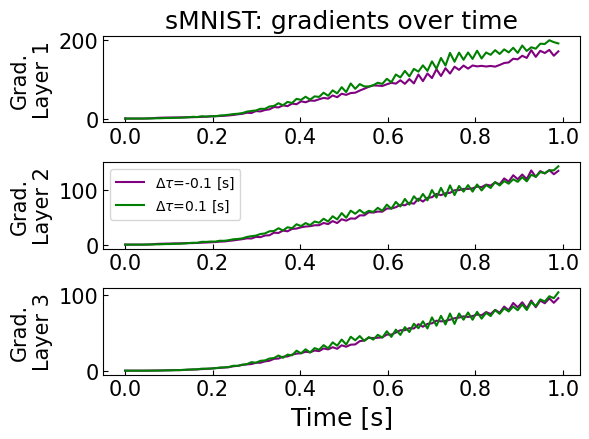

In [32]:
fig, ax = plt.subplots( 3,1, figsize=(6, 4.5) )
# colors=['purple', 'gray', 'green']
colors=['purple', 'green']
for d, delta_tau in enumerate(delta_tau_list):
    # first layer
    ax[0].plot( np.arange( steps )/steps, np.mean(G1, axis=0)[d], color=colors[d] )
    ax[0].set_ylabel('Grad.\nLayer 1', size=15)
    ax[0].tick_params( direction='in', labelsize=15 )
    # second layer
    ax[1].plot( np.arange( steps )/steps, np.mean(G2, axis=0)[d], color=colors[d], label=r'$\Delta \tau$={:.1f} [s]'.format( delta_tau ) )
    ax[1].set_ylabel('Grad.\nLayer 2', size=15)
    ax[1].tick_params( direction='in', labelsize=15 )
    # third layer
    ax[2].plot( np.arange( steps )/steps, np.mean(G3, axis=0)[d], color=colors[d] )
    ax[2].set_ylabel('Grad.\nLayer 3', size=15)
    ax[2].tick_params( direction='in', labelsize=15 )

ax[0].set_title('sMNIST: gradients over time', size=18)
ax[2].set_xlabel('Time [s]', size=18)
ax[1].legend( prop={'size':10} )
plt.tight_layout()

### Gradients over time on the SHD

In [11]:
# Hyperparameter setting
args.train_alpha = False
args.hierarchy_tau = 'linear'
args.distrib_tau = 'normal'
args.recurrent = False
args.seed = 1
args.n_layers = 3
args.n_hid = 32
# LR and regularizers
args.l2_alpha_sd = 1e-3
args.n_epochs = 60
args.verbose = False
# task-specific parameters
args.dataset_name = 'shd'
args.decoder = 'cum'
args.tau_out = 0.05
args.nb_steps               = 100
args.n_in                   = 700
args.n_out                  = 20
args.timestep               = 1/args.nb_steps # s
args.tau_mem                = 0.1
args.tau_out                = 0.05
args.delta_tau              = 0.0
args.dropout                = 0.1
args.lr                     = 0.01
args.batch_size             = 256

In [25]:
seed_list      = [0,1,2,3,4,5,6,7,8,9]
delta_tau_list = [-0.15, 0.15]

G1, G2, G3 = [], [], []
for s, seed in enumerate(seed_list):
    # let's set the seed
    args.seed = seed
    np.random.seed( seed )
    random.seed(seed)

    ### from the training function
    train_dl, val_dl, test_dl = get_dataloader( args=args, verbose=True )

    G1tmp, G2tmp, G3tmp = [], [], []
    for delta_tau in delta_tau_list:

        # let's set the delta_tau
        args.delta_tau = delta_tau

        # First epochs in which we train
        args.nb_steps = 100
        # args.n_epochs = 1
        # args.verbose  = False
        # train_loss, test_acc, val_acc, net_params = train_hsnn( args = args, wandb_flag=False )


        # initialize the gradient
        original_nb_steps = 100 #args.nb_steps
        grads_hist = []
        grads_hist_l1 = []
        grads_hist_l2 = []
        grads_hist_l3 = []
        t_start = 5
        for t in range( t_start, original_nb_steps, 5 ):

            # Randon Number Generator
            key = jax.random.PRNGKey(args.seed)
            key, key_model = jax.random.split(key, 2)

            # define the optimizer --> In this experiment we choose SGD
            opt_init, opt_update, get_params = optimizers.sgd(step_size=pw_lr)

            # initialize the parameters (and states)
            net_params, net_states = params_initializer( key_model, args )
            opt_state = opt_init(net_params)
            train_params = get_params(opt_state)

            # draw a batch of data
            args.nb_steps = t
            x,y = next(iter(train_dl))
            y = one_hot(y, args.n_out)

            # forward pass and compute the gradients
            value, grads = value_and_grad(loss, has_aux=True, argnums=(1))(key, train_params, net_states, x[:,:t], y, 0, dropout_rate=0, dilation=0, dilation_delta=0)

            # collect the gradients through time
            grads_hist.append(grads)
            if t == t_start:
                grads_hist_l1.append( grads[0][0][0] )
                grads_hist_l2.append( grads[1][0][0] )
                grads_hist_l3.append( grads[2][0][0] )
            else: 
                grads_hist_l1.append( grads[0][0][0] - grads_hist_l1[-1] )
                grads_hist_l2.append( grads[1][0][0] - grads_hist_l2[-1] )
                grads_hist_l3.append( grads[2][0][0] - grads_hist_l3[-1] )

        # compute the Euclidean norm over time
        steps = len( grads_hist_l1 )
        grads_hist_l1_norm = np.linalg.norm( np.array( grads_hist_l1 ).reshape( steps, -1 ), axis=-1, keepdims=False )
        grads_hist_l2_norm = np.linalg.norm( np.array( grads_hist_l2 ).reshape( steps, -1 ), axis=-1, keepdims=False )
        grads_hist_l3_norm = np.linalg.norm( np.array( grads_hist_l3 ).reshape( steps, -1 ), axis=-1, keepdims=False )
        
        # collect in the wrapper
        G1tmp.append( grads_hist_l1_norm )
        G2tmp.append( grads_hist_l2_norm )
        G3tmp.append( grads_hist_l3_norm )

        print( f'-- Delta Tau {delta_tau} completed' )
        
    # collect in the wrapper
    G1.append( G1tmp )
    G2.append( G2tmp )
    G3.append( G3tmp )
            
    print( f'Seed {seed} completed' )

Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
-- Delta Tau -0.15 completed
-- Delta Tau 0.15 completed
Seed 0 completed
Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
-- Delta Tau -0.15 completed
-- Delta Tau 0.15 completed
Seed 1 completed
Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
-- Delta Tau -0.15 completed
-- Delta Tau 0.15 completed
Seed 2 completed
Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
-- Delta Tau -0.15 completed
-- Delta Tau 0.15 completed
Seed 3 completed
Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
-- Delta Tau -0.15 completed
-- Delta Tau 0.15 completed
Seed 4 completed
Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
-- Delta Tau -0.15 completed
-- Delta Tau 0.15 completed
Seed 5 completed
Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264
-- Delta Tau -0.15 completed
-- Delta Tau 0.15 completed
Seed 6 completed
Train DL size: 6524,

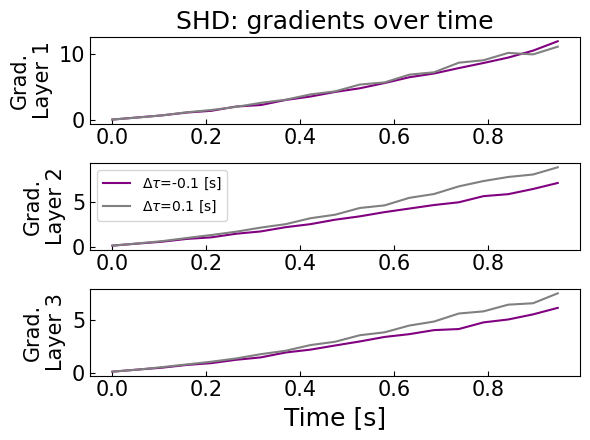

In [26]:
fig, ax = plt.subplots( 3,1, figsize=(6, 4.5) )
# colors=['purple', 'gray', 'green']
colors=['purple', 'green']
for d, delta_tau in enumerate(delta_tau_list):
    # first layer
    ax[0].plot( np.arange( steps )/steps, np.mean(G1, axis=0)[d], color=colors[d] )
    ax[0].set_ylabel('Grad.\nLayer 1', size=15)
    ax[0].tick_params( direction='in', labelsize=15 )
    # second layer
    ax[1].plot( np.arange( steps )/steps, np.mean(G2, axis=0)[d], color=colors[d], label=r'$\Delta \tau$={:.1f} [s]'.format( delta_tau ) )
    ax[1].set_ylabel('Grad.\nLayer 2', size=15)
    ax[1].tick_params( direction='in', labelsize=15 )
    # third layer
    ax[2].plot( np.arange( steps )/steps, np.mean(G3, axis=0)[d], color=colors[d] )
    ax[2].set_ylabel('Grad.\nLayer 3', size=15)
    ax[2].tick_params( direction='in', labelsize=15 )

ax[0].set_title('SHD: gradients over time', size=18)
ax[2].set_xlabel('Time [s]', size=18)
ax[1].legend( prop={'size':10} )
plt.tight_layout()